In [1]:
import networkx as nx
import itertools
import matplotlib.pyplot as plt

## Working on a Toy Example first

In [2]:
file_path = "toy_network.txt"

In [3]:
G = nx.read_weighted_edgelist(file_path, nodetype=int, create_using=nx.Graph())

## Declaring variables
#### OD_nodes --> Origin and Destination Pair
#### charger_nodes --> Nodes where there is a charging station
#### distance_range --> Range vehicle can travel with full charge

In [4]:
OD_nodes = [0, 10]
charger_nodes = [2, 4, 7, 9]
concerned_nodes = sorted(OD_nodes + charger_nodes)
distance_range = 150.0
node_combinations = list(itertools.combinations(concerned_nodes, 2))

## Visualize the Network

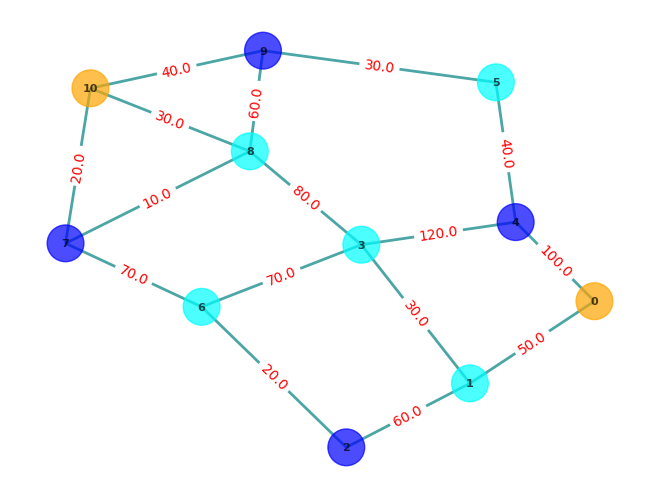

In [5]:
node_colors = []
for node in G.nodes():
    if node in OD_nodes:
        node_colors.append('orange')
    elif node in charger_nodes:
        node_colors.append('blue')
    else:
        node_colors.append('cyan')

edge_colors = 'teal'

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True, font_weight = 'bold' , node_size = 700 , node_color=node_colors, font_size=8, font_color='black', edge_color=edge_colors, width=2, alpha=0.7)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.show()

### Check if a path is a subpath
For example [1,3,4] is a subpath of [0,1,3,4,6,7]

In [6]:
def is_subpath(subpath, path):
    n = len(subpath)
    m = len(path)
    for i in range(m - n + 1):
        if path[i:i + n] == subpath:
            return True
    return False

### Remove subpaths
Subpaths of a shortest path are also shortest paths, by optimality principle of shortest paths

In [7]:
def remove_subpaths(paths, distances):
    new_paths = []
    new_distances = []

    for i in range(len(paths)):
        add_path = True
        for j in range(len(paths)):
            if i != j and is_subpath(paths[i], paths[j]):
                add_path = False
                break
        if add_path:
            new_paths.append(paths[i])
            new_distances.append(distances[i])
    return new_paths, new_distances

#### Only consider the paths that fall within the range of vehicle

In [8]:
sh_path_ranged = []
sh_path_dist_ranged = []

In [9]:
for s, t in node_combinations:
    shortest_distance = nx.shortest_path_length(G, source=s, target=t, weight='weight')

    if shortest_distance <= distance_range:
        shortest_path = nx.shortest_path(G, source=s, target=t, weight='weight')
        if OD_nodes[1] in shortest_path and shortest_path.index(OD_nodes[1]) == len(shortest_path) - 1:
            sh_path_ranged.append(shortest_path)
            sh_path_dist_ranged.append(shortest_distance)
        elif OD_nodes[1] not in shortest_path:
            sh_path_ranged.append(shortest_path)
            sh_path_dist_ranged.append(shortest_distance)

sh_path_ranged, sh_path_dist_ranged = remove_subpaths(sh_path_ranged, sh_path_dist_ranged)

#### Merging subpaths

In [10]:
merged_array_repo = []
distance_repo = []

#### Merge subpaths for which end node of predecessor subpath is the same as start node for the successor subpath

In [11]:
def merge_arrays(arr1, arr2, dist1, dist2):
    if not arr1 or not arr2:
        return [], 0.0

    merged_array = arr1 + arr2[1:]
    merged_distance = dist1 + dist2

    return merged_array, merged_distance

#### Recursively keep merging until we get a final set of valid shortest subpaths to allow the vehicle to travel through intermediate nodes of concern

In [12]:
def recursive_merging(input_array, input_distances):
    global merged_array_repo
    merged_array = []
    combined_listing = list(itertools.combinations(input_array, 2))
    combined_array = [list(combination) for combination in combined_listing]

    to_remove = []

    counter = 0
    for comb in combined_array:
        if comb[0][-1] == comb[1][0]:
            counter += 1

    if counter == 0:
        return merged_array_repo, distance_repo

    for comb in combined_array:
        if comb[0][-1] == comb[1][0]:
            merged_array, merged_distance = merge_arrays(
                comb[0], comb[1:][0], input_distances[input_array.index(comb[0])], input_distances[input_array.index(comb[1:][0])]
            )
            merged_array_repo.append(merged_array)
            distance_repo.append(merged_distance)
            to_remove.extend([comb[0], comb[1:][0]])

    merged_array_repo = [sublist for sublist in merged_array_repo if sublist not in to_remove]

    return recursive_merging(merged_array_repo, distance_repo)

#### Obtain merged paths and distances

In [13]:
list_of_paths, list_of_distances = recursive_merging(sh_path_ranged, sh_path_dist_ranged)

#### Eliminate paths that don't begin at origin and end at destination

In [14]:
valid_paths = []
valid_distances = []
for each_path, each_distance in zip(list_of_paths, list_of_distances):
    if each_path[0] == OD_nodes[0] and each_path[-1] == OD_nodes[1]:
        valid_paths.append(each_path)
        valid_distances.append(each_distance)

### Final shortest path

In [15]:
if distance_repo:
    min_distance_index = distance_repo.index(min(distance_repo))

    # Retrieve the corresponding path from list_of_paths
    shortest_path = list_of_paths[min_distance_index]
    shortest_distance = list_of_distances[min_distance_index]

    print(f"\nShortest Path: {shortest_path}, Shortest Distance: {shortest_distance}")
else:
    print("\nNo valid paths found.")


Shortest Path: [0, 4, 5, 9, 10], Shortest Distance: 210.0


## Visualize Output

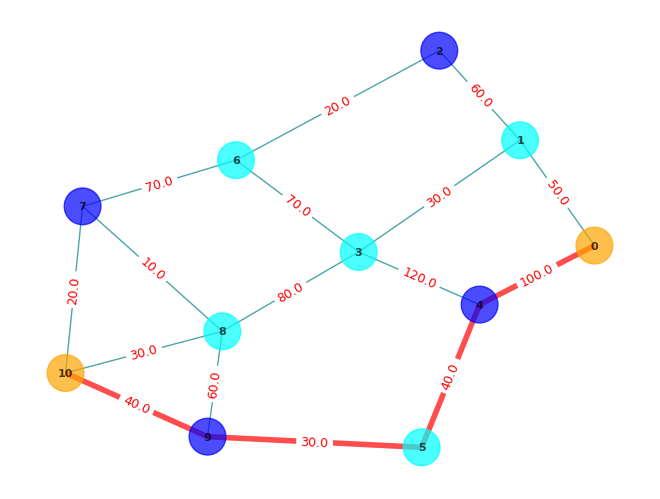

In [22]:
H = G.copy()
for i in range(len(shortest_path) - 1):
    H[shortest_path[i]][shortest_path[i+1]]['width'] = 4.0
    H[shortest_path[i]][shortest_path[i+1]]['color'] = 'red'

edge_width = [H[u][v].get('width', 1.0) for u, v in H.edges()]
edge_colors = [H[u][v].get('color', 'teal') for u, v in H.edges()]

pos = nx.spring_layout(H)
nx.draw(H, pos, with_labels = True, font_weight = 'bold' , node_size = 700 , node_color=node_colors, font_size=8, font_color='black', edge_color=edge_colors, width=edge_width, alpha=0.7)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=9)

plt.show()